In [74]:
# -*- coding: utf-8 -*-

"""
Title: Vehicle routing problem
Course: ME44206 Quantitative Methods for Logistics
Authors:
    Stefan Klaassen - 6076947
    Peter Nederveen - 
    Britt van de Geer - 
    Bart Verzijl - 
Last updated: 2025-12-02
Version: 1.0

Usage:
    ../
     ├── AssignmentQ2_Group5_B.py
     └── data_small.txt

Dependencies:
    Python 3.13.7+
    gurobipy

"""

# IMPORTS
#==================================================================================================

import math, sys
from pathlib import Path
from dataclasses import dataclass
from collections.abc import Generator
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch


# MODEL DATA
#==================================================================================================

# CONSTANTS
MAX_TIME = 10000
MAX_BATTERY = 2000
VEHICLES = 4
VEHICLE_PACE = 2
VEHICLE_CAPACITY = 120
VEHICLE_RANGE = 110
VEHICLE_CHARGE_RATE = 1.0
VEHICLE_DISCHARGE_RATE = 1.0

@dataclass
class Node:
    LOC_ID: int
    XCOORD: int
    YCOORD: int
    DEMAND: int
    READYTIME: int
    DUETIME: int
    SERVICETIME: int
    CHARGING: int

def get_node_data(filename: str) -> list[Node]:
    try:
        file = Path(filename)
        if not file.is_absolute():
            file = Path.cwd() / filename
        assert file.is_file(), f"Kan '{filename}' niet vinden in '{file.parent}'."
    except Exception as e: 
        print(e)
        sys.exit(1)
    data = []
    if not file.exists():
        raise FileNotFoundError(f"Data file not found: {file}")
    with file.open('r') as f:
        for line in f:
            row = [int(v) for v in line.strip().split()]
            instance = Node(*row)
            data.append(instance)
    return data

def build_distance_mat(data: list[Node]) -> list[list[float]]:

    def _euclidean_distance(node1: Node, node2: Node) -> float:
        return math.sqrt( (node2.XCOORD - node1.XCOORD)**2 + (node2.YCOORD - node1.YCOORD)**2 )

    mat = []
    for i, start in enumerate(data):
        row = []
        for j, dest in enumerate(data):
            if i == j:
                row.append(float('inf'))
                continue
            row.append(_euclidean_distance(start, dest))
        mat.append(row)
    return mat

node_data = get_node_data('data_small.txt')

# SETS
#==================================================================================================

N = range(len(node_data))
V = range(VEHICLES)

# PARAMETERS
#==================================================================================================

c  = VEHICLE_CAPACITY                       # Vehicle capacity per vehicle v
d  = build_distance_mat(node_data)          # Distance between node i and j
s  = VEHICLE_PACE                           # Pace of vehicle v
q  = [n.DEMAND for n in node_data]          # Demand at node i
bm = VEHICLE_RANGE                          # Maximum battery capacity of vehicle v
bc = VEHICLE_CHARGE_RATE                    # Energy charging rate
bd = VEHICLE_DISCHARGE_RATE                 # Energy discharging rate
bs = [n.CHARGING for n in node_data]        # Charger station at node i
ts = [n.SERVICETIME for n in node_data]     # Minimal service time at node i
tr = [n.READYTIME for n in node_data]       # Ready time at node i
td = [n.DUETIME for n in node_data]         # Due time at node i


# MODEL DEFINITION
#==================================================================================================

# MODEL
model = Model('Vehicle Routing Problem')


# DESISION VARIABLES
tau_a_i = model.addVars(N, lb=0, vtype = GRB.CONTINUOUS, name='τ^a')        # Time of arrival at node i
tau_d_i = model.addVars(N, lb=0, vtype = GRB.CONTINUOUS, name='τ^d')        # Time of departure at node i
tau_s_i = model.addVars(N, lb=0, vtype = GRB.CONTINUOUS, name='τ^s')        # Time of Service start at node i
tau_c_i = model.addVars(N, lb=0, vtype = GRB.CONTINUOUS, name='τ^c')        # Time at node i with charging
z_iv    = model.addVars(N, V, vtype=GRB.BINARY, name='z')                   # If 1, node is visited by vehicle v 
beta_iv = model.addVars(N, V, lb=0, name='β')                               # Battery level of vehicle v at node i
x_ijv   = model.addVars(N, N, V, vtype=GRB.BINARY, name='x')                # If 1, indicates if vehicle v travels from node i to j


# OBJECTIVE
model.ModelSense = GRB.MINIMIZE
obj = quicksum(d[i][j] * x_ijv[i, j, v] for i in N for j in N if i != j for v in V)
obj_2 = -quicksum(tau_d_i[i] for i in N)  # negative sign to express maximization
obj_3 = quicksum(tau_c_i[i] for i in N for v in V)
model.setObjectiveN(obj,   index=0, priority=3, weight=1, name="distance")
model.setObjectiveN(obj_2, index=1, priority=2, weight=0.0000001, name="departure_time") # added objective to prevent time loss
model.setObjectiveN(obj_3, index=2, priority=1, weight=0.0000001, name="battery_level") # added objective to prevent battery losses

# CONSTRAINTS
constraints = {
    'visit_constraint':
    (quicksum(z_iv[i, v] for v in V) == 1 for i in N[1:]),

    'depot_constraint':
    quicksum(z_iv[0, v] for v in V) == VEHICLES,

    'vehicle_capacity_constraint': 
    (quicksum(q[i] * z_iv[i, v] for i in N) <= c for v in V),

    'departure_constraint':  
    (quicksum(x_ijv[i, j, v] for j in N) == quicksum(x_ijv[j, i, v]
        for j in N) for i in N for v in V),

    'departure_constraint(2)':  
    (quicksum(x_ijv[i, j, v] for j in N) == z_iv[i, v] for i in N for v in V),

    'no_self_loops':
    (x_ijv[i, i, v] == 0 for i in N for v in V),

    'time_constraint':
    (tau_d_i[i] + (d[i][j] * s) - MAX_TIME * (1 - x_ijv[i, j, v]) <= tau_a_i[j]
        for i in N for j in N[1:] if i != j for v in V),

    'end_time_constraint':
    (tau_d_i[i] + (d[i][0] * s) - MAX_TIME * (1 - x_ijv[i, 0, v]) <= td[0]
        for i in N[1:] for v in V),
    

    'time_window_constraint_start':
    (tr[i] <= tau_s_i[i] for i in N),

    'time_window_constraint_end':
    (tau_s_i[i] <= td[i] for i in N),

    'time_service_constraint_start':
    (tau_s_i[i] >= tau_a_i[i] for i in N),
     
    'service_time_constraint':
    (tau_d_i[i] - tau_s_i[i] >= ts[i] for i in N),

    'service_time_constraint_battery':
    (tau_d_i[i] - tau_s_i[i] >= tau_c_i[i] for i in N),



    'battery_capacity_constraint_bottom':
    ((beta_iv[i, v] - (d[i][j] * s * bd) + tau_c_i[i] * bc * bs[i]) + (1 - x_ijv[i, j, v]) * MAX_BATTERY >= 0 
        for i in N for j in N if i != j for v in V),

    'battery_capacity_constraint_top':
    ((beta_iv[i, v] + tau_c_i[i] * bc * bs[i]) - (1 - x_ijv[i, j, v]) * MAX_BATTERY <= bm 
        for i in N for j in N for v in V),
    
    'battery_link_constraint':
    (beta_iv[i, v] - (d[i][j] * s * bd) + tau_c_i[i] * bc * bs[i] + (1 - x_ijv[i, j, v]) * MAX_BATTERY >= beta_iv[j, v]
        for i in N for j in N[1:] if i != j for v in V),

    'initial_battery_constraint':
    (beta_iv[0, v] == bm for v in V),

    'charging_time_constraint':
    (tau_c_i[i] * (1 - bs[i]) == 0 for i in N),
}

for name, con in constraints.items():
    if isinstance(con, Generator): model.addConstrs(con, name=name) 
    else: model.addConstr(con, name=name)




# SOLVE
#==================================================================================================

# model.computeIIS()
# print('IIS written to model.iis')
# # optional: list IIS constraints
# print([c.ConstrName for c in model.getConstrs() if c.IISConstr == 1])

model.update()
model.write('TSPmodel.lp')
setattr(model.Params, 'timeLimit', 3600)
model.optimize()
model.write('TSPmodel.sol')

solved = model.Status == GRB.OPTIMAL

if __name__ == "__main__":
    print('\n')
    print('Success, obj:', model.ObjVal) if solved else print('Failed')





Set parameter TimeLimit to value 3600
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  3600

Optimize a model with 7131 rows, 2016 columns and 23752 nonzeros
Model fingerprint: 0xb12bba81
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  3600

Optimize a model with 7131 rows, 2016 columns and 23752 nonzeros
Model fingerprint: 0xb12bba81
Variable types: 168 continuous, 1848 integer (1848 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
Variable types: 168 continuous, 1848 integer (1848 binary)
Coefficient statis



Solution: [[(0, 5), (5, 14), (12, 0), (14, 15), (15, 16), (16, 12)], [(0, 17), (13, 18), (17, 13), (18, 19), (19, 0)], [(0, 20), (6, 9), (8, 0), (9, 11), (10, 8), (11, 10), (20, 6)], [(0, 3), (1, 7), (2, 1), (3, 2), (4, 0), (7, 4)]]


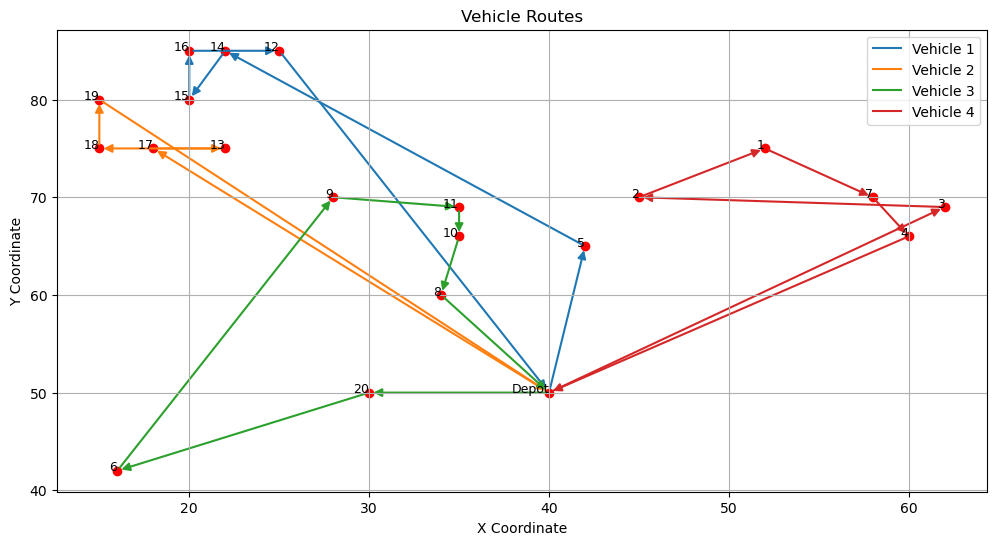

In [75]:
if solved:
    # Extract solution
    solution = []
    for v in V:
        route = []
        for i in N:
            for j in N:
                if x_ijv[i, j, v].X > 0.5:
                    route.append((i, j))
        solution.append(route)
    
    print('\n'*2, 'Solution: ', solution, sep='')
    plt.figure(figsize=(12, 6))
    # Plotting points
    x_coords = [node_data[0].XCOORD]
    y_coords = [node_data[0].YCOORD]
    for n in node_data[1:]:
        x_coords.append(n.XCOORD)
        y_coords.append(n.YCOORD)
    plt.scatter(x_coords, y_coords, color='red')
    plt.text(node_data[0].XCOORD, node_data[0].YCOORD, 'Depot', fontsize=9, ha='right')
    for i, n in enumerate(node_data[1:], start=1):
        plt.text(n.XCOORD, n.YCOORD, f'{i}', fontsize=9, ha='right')


    # Plotting the routes put arrows between the nodes
    cmap = plt.get_cmap('tab10')

    for v, route in enumerate(solution):
        if not route:
            continue
        color = cmap(v % 10)
        plt.plot([], [], color=color, label=f'Vehicle {v+1}')
        ax = plt.gca()
        for i_idx, j_idx in route:
            x1, y1 = node_data[i_idx].XCOORD, node_data[i_idx].YCOORD
            x2, y2 = node_data[j_idx].XCOORD, node_data[j_idx].YCOORD
            if x1 == x2 and y1 == y2:
                continue
            arr = FancyArrowPatch((x1, y1), (x2, y2),
                                 arrowstyle='-|>', mutation_scale=12,
                                 color=color, linewidth=1.5,
                                 shrinkA=3, shrinkB=3)
            ax.add_patch(arr)

    plt.title('Vehicle Routes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid()
    plt.show()



Solution in sequence: [[0, 5, 14, 15, 16, 12, 0], [0, 17, 13, 18, 19, 0], [0, 20, 6, 9, 11, 10, 8, 0], [0, 3, 2, 1, 7, 4, 0]]


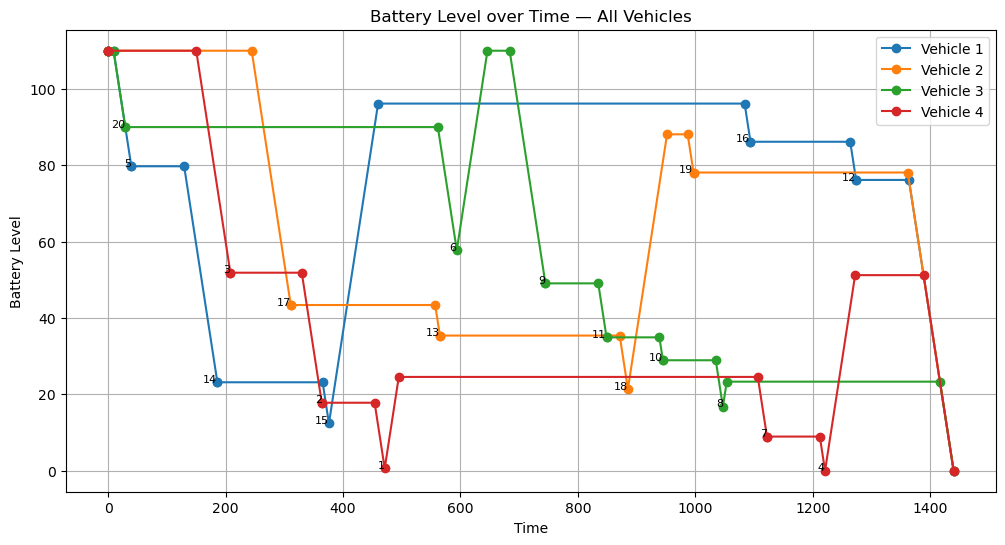



time of arrival: [39, 186, 376, 1094, 1274, 1440, 311, 565, 885, 997, 1440, 29, 594, 745, 849, 945, 1047, 1440, 208, 364, 471, 1122, 1221, 1440]


In [76]:

if solved:
    solution = []
    for v in V:
        route = [0]
        i = 0
        # follow arcs from the depot until we return to depot or no outgoing arc is found
        while True:
            found = False
            for j in N:  # iterate only over valid node indices
                if x_ijv[i, j, v].X > 0.5:
                    if route[-1] != j:
                        route.append(j)
                    i = j
                    found = True
                    break
            # stop if no outgoing arc or we've returned to the depot
            if not found or i == 0:
                break
        solution.append(route)
    
    print('\n'*2, 'Solution in sequence: ', solution, sep='')

    # time of arrival, charging time, waiting time, battery level




plt.figure(figsize=(12, 6))
cmap = plt.get_cmap('tab10')
timeofarrival = []
for vehicle, route in enumerate(solution):
    
    if not route:
        continue
    timeofarrival_v = []
    time = []
    battery = []
    TEST =1
    for i in route[1:-1]:  # Exclude the last node to avoid index error
        if TEST==1:
            time.extend([
            0,
            0,
            tau_a_i[i].X - d[0][i] * s
            ])
            battery.extend([
            bm,
            bm,
            bm
            ])
            TEST=0

        timeofarrival_v.append(round(tau_a_i[i].X))
        time.extend([
            tau_a_i[i].X,
            tau_a_i[i].X + tau_c_i[i].X,
            tau_d_i[i].X
        ])
        battery.extend([
            beta_iv[i, vehicle].X,
            beta_iv[i, vehicle].X + tau_c_i[i].X * bc * bs[i],
            beta_iv[i, vehicle].X + tau_c_i[i].X * bc * bs[i]
        ])
        # print(f'Node {i}, Vehicle {round(vehicle)}: Time Arrival={round(tau_a_i[i].X)}, Charging Time={round(tau_c_i[i].X)}, Waiting Time={round(tau_w_i[i].X)}, Battery Level={round(beta_iv[i, vehicle].X)}, After Charging={round(beta_iv[i, vehicle].X + tau_c_i[i].X * bc * bs[i])}, charging station={bs[i]} ')
        plt.text(tau_a_i[i].X, beta_iv[i, vehicle].X, f'{i}', fontsize=8, ha='right')
        last_i = i
    timeofarrival_v.append(round(tau_d_i[last_i].X + d[last_i][0] * s))
    time.append(tau_d_i[last_i].X + d[last_i][0] * s)
    battery.append(beta_iv[last_i, vehicle].X     -    d[last_i][0] * s * bd  +  tau_c_i[last_i].X * bc * bs[last_i])
    timeofarrival.extend(timeofarrival_v)

    plt.plot(time, battery, marker='o', color=cmap(vehicle % 10), label=f'Vehicle {vehicle+1}')
plt.title(f'Battery Level over Time — All Vehicles')
plt.xlabel('Time')
plt.ylabel('Battery Level')
plt.legend()
plt.grid()
plt.show()

print('\n'*2,'time of arrival: ' , timeofarrival, sep='')





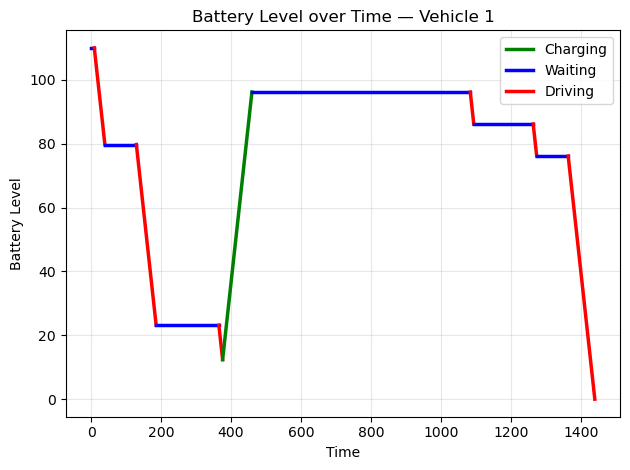

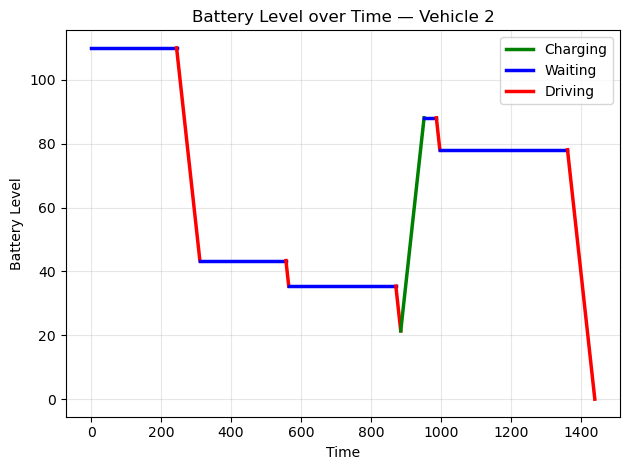

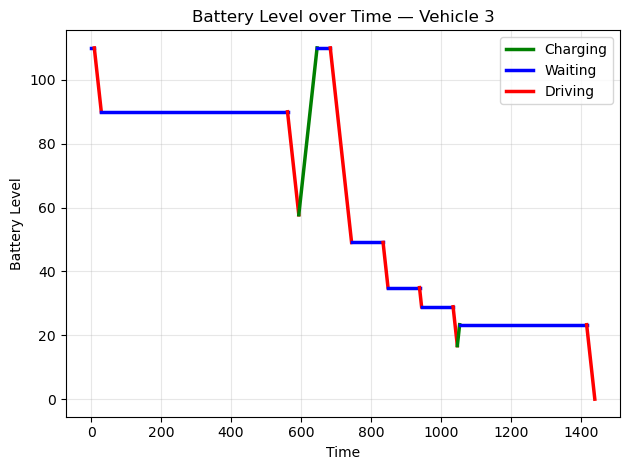

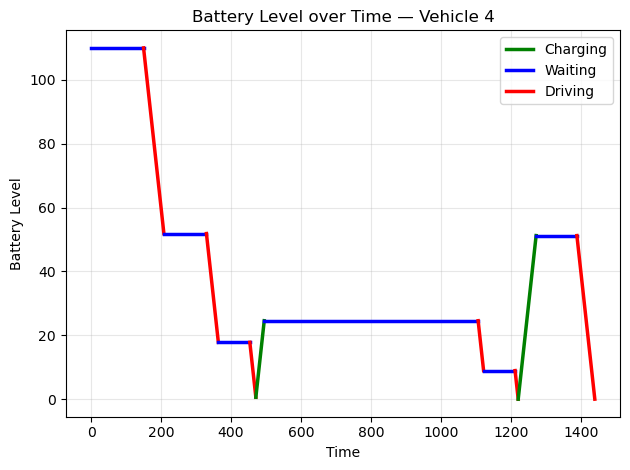

In [67]:
cmap = plt.get_cmap('tab10')

for vehicle, route in enumerate(solution):
    if not route or len(route) < 3:
        continue
    
    plt.figure(figsize=(12, 6))#figsize=(12, 6)
    time = []
    battery = []
    TEST = 1
    
    # Build time and battery arrays (same as previous cell)
    for i in route[1:-1]:  # Exclude depot (first and last nodes)
        if TEST == 1:
            time.extend([0, 0, tau_a_i[i].X - d[0][i] * s])
            battery.extend([bm, bm, bm])
            TEST = 0
        
        time.extend([
            tau_a_i[i].X,
            tau_a_i[i].X + tau_c_i[i].X,
            tau_d_i[i].X
        ])
        battery.extend([
            beta_iv[i, vehicle].X,
            beta_iv[i, vehicle].X + tau_c_i[i].X * bc * bs[i],
            beta_iv[i, vehicle].X + tau_c_i[i].X * bc * bs[i]
        ])
    
    # Add final segment back to depot
    last_customer = route[-2]
    t_last_depart = tau_d_i[last_customer].X
    t_arrive_depot = t_last_depart + d[last_customer][0] * s
    b_last_depart = beta_iv[last_customer, vehicle].X + tau_c_i[last_customer].X * bc * bs[last_customer]
    b_arrive_depot = b_last_depart - d[last_customer][0] * s * bd
    
    time.extend([t_last_depart, t_arrive_depot])
    battery.extend([b_last_depart, b_arrive_depot])
    
    # Plot segments with color based on battery gradient
    for k in range(1, len(time)):
        t_prev, t_curr = time[k-1], time[k]
        b_prev, b_curr = battery[k-1], battery[k]
        
        # Determine color based on battery change (gradient)
        battery_diff = b_curr - b_prev
        
        if battery_diff > 0.01:  # Battery increasing = charging (green)
            color = 'green'
        elif abs(battery_diff) <= 0.01:  # Battery flat = waiting (blue)
            color = 'blue'
        else:  # Battery decreasing = driving (red)
            color = 'red'
        
        plt.plot([t_prev, t_curr], [b_prev, b_curr], color=color, linewidth=2.5)
    
    # Legend
    plt.plot([], [], color='green', linewidth=2.5, label='Charging')
    plt.plot([], [], color='blue', linewidth=2.5, label='Waiting')
    plt.plot([], [], color='red', linewidth=2.5, label='Driving')
    
    plt.title(f'Battery Level over Time — Vehicle {vehicle+1}')
    plt.xlabel('Time')
    plt.ylabel('Battery Level')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

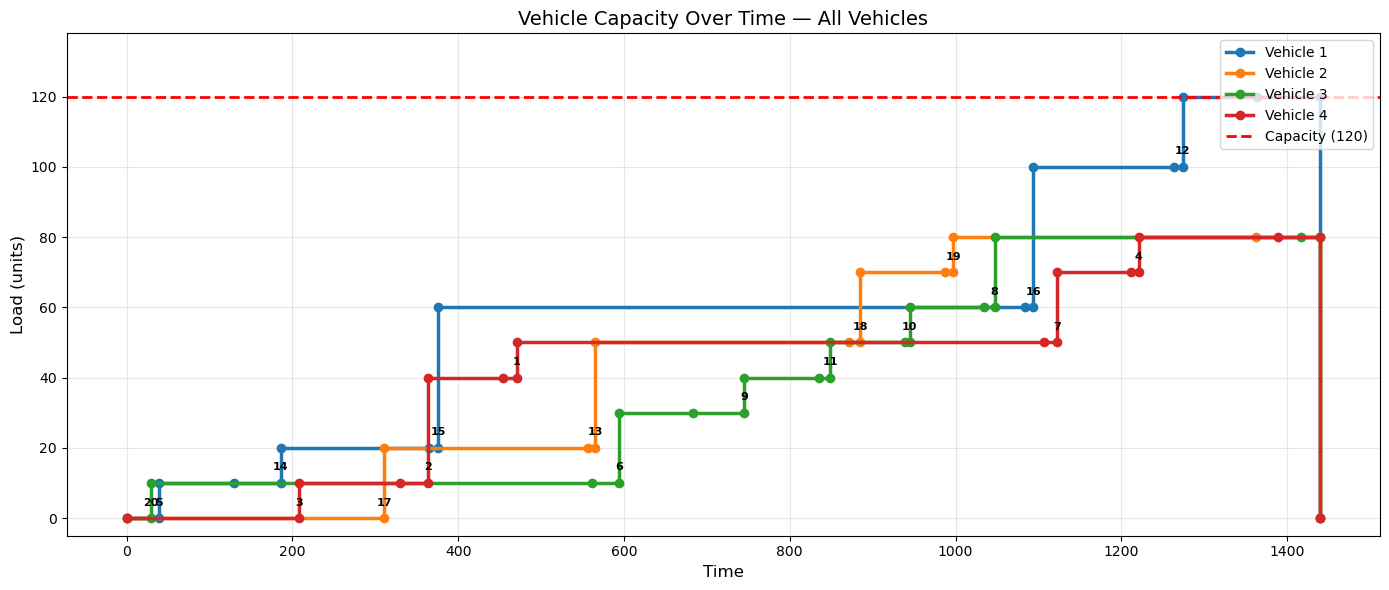

In [73]:
if solved:
    # Plot capacity usage over time for all vehicles in one plot
    plt.figure(figsize=(14, 6))
    cmap = plt.get_cmap('tab10')
    
    for vehicle, route in enumerate(solution):
        if not route or len(route) < 3:
            continue
        
        nodes = route[1:-1]  # Exclude depot
        time_points = []
        load_points = []
        cumulative = 0
        
        # Start at depot at time 0
        time_points.append(0)
        load_points.append(0)
        
        # Add each customer visit with its time and cumulative load
        for node in nodes:
            # Arrival time
            arrival_time = tau_a_i[node].X
            time_points.append(arrival_time)
            load_points.append(cumulative)
            
            # After picking up load
            time_points.append(arrival_time)
            cumulative += q[node]
            load_points.append(cumulative)
            
            # Departure time
            departure_time = tau_d_i[node].X
            time_points.append(departure_time)
            load_points.append(cumulative)
        
        # Return to depot
        last_customer = route[-2]
        return_time = tau_d_i[last_customer].X + d[last_customer][0] * s
        time_points.append(return_time)
        load_points.append(cumulative)
        
        time_points.append(return_time)
        load_points.append(0)
        
        # Plot the load over time
        color = cmap(vehicle % 10)
        plt.plot(time_points, load_points, marker='o', linewidth=2.5, 
                markersize=6, color=color, label=f'Vehicle {vehicle+1}')
        
        # Add node labels at arrival times
        node_idx = 0
        for i, (t, l) in enumerate(zip(time_points, load_points)):
            if node_idx < len(nodes) and i > 0 and i < len(time_points) - 2:
                # Label at arrival point (every 3rd point starting from index 1)
                if (i - 1) % 3 == 0:
                    plt.text(t, l + 3, f'{nodes[node_idx]}', fontsize=8, 
                            ha='center', va='bottom', color='black', weight='bold')
                    node_idx += 1
    
    # Add capacity limit line
    plt.axhline(y=VEHICLE_CAPACITY, color='red', linestyle='--', 
                linewidth=2, label=f'Capacity ({VEHICLE_CAPACITY})')
    
    # Styling
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Load (units)', fontsize=12)
    plt.title('Vehicle Capacity Over Time — All Vehicles', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.ylim(-5, VEHICLE_CAPACITY * 1.15)
    plt.tight_layout()
    plt.show()

